# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf


# Import Dataset

In [2]:
df = pd.read_csv('brent.csv')

In [3]:
df.shape

(9096, 2)

In [4]:
df.head()

,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


In [5]:
df.describe()

,Price
count,9096.000000
mean,48.740180
std,32.874995
min,9.100000
25%,19.100000
50%,39.750000
75%,71.022500
max,143.950000


In [6]:
df.isnull().sum()

Date     0
Price    0
dtype: int64

In [8]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d')

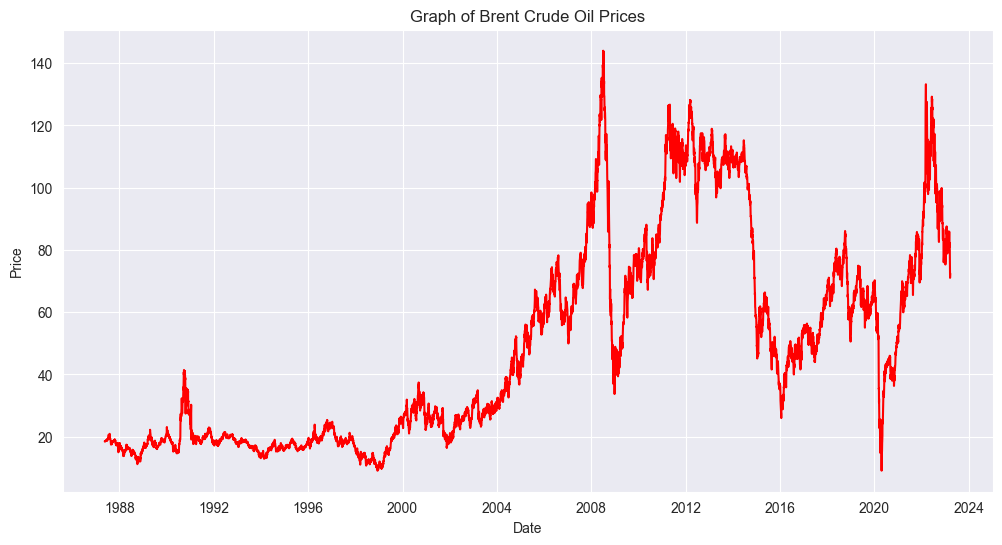

In [9]:
sns.set_style('darkgrid')
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x='Date', y='Price', color='red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Graph of Brent Crude Oil Prices')
plt.show()

In [10]:
df.dtypes

Date     datetime64[ns]
Price           float64
dtype: object

In [19]:
df = pd.read_csv('brent.csv', index_col="Date")

In [21]:
df.head()

,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63


# Splitting dataset

In [22]:
from sklearn.model_selection import train_test_split

# Split the data into training, validation, and test sets
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.15)
test_size = len(df) - train_size - val_size

In [23]:
print('Train Size=', train_size)
print('Validation Size=', val_size)
print('Test Size=', test_size)

Train Size= 6367
Validation Size= 1364
Test Size= 1365


In [24]:
train_data, val_data, test_data = np.split(df, [train_size, train_size + val_size])


# Scale the Data

In [25]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
val_data = scaler.transform(val_data)
test_data = scaler.transform(test_data)

# Define the number of time steps and features

In [26]:
time_steps = 50
features = 1

# Creating the Sequence

In [27]:
# Create training sequences
train_sequences = []
train_labels = []
for i in range(time_steps, len(train_data)):
    train_sequences.append(train_data[i - time_steps:i])
    train_labels.append(train_data[i])
train_sequences = np.array(train_sequences)
train_labels = np.array(train_labels)

In [28]:
# Create validation sequences
val_sequences = []
val_labels = []
for i in range(time_steps, len(val_data)):
    val_sequences.append(val_data[i - time_steps:i])
    val_labels.append(val_data[i])
val_sequences = np.array(val_sequences)
val_labels = np.array(val_labels)

In [29]:
#Create test sequences
test_sequences = []
test_labels = []
for i in range(time_steps, len(test_data)):
    test_sequences.append(test_data[i - time_steps:i])
    test_labels.append(test_data[i])
test_sequences = np.array(test_sequences)
test_labels = np.array(test_labels)

# Define the LSTM model

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [31]:
# Define the model architecture
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, features)))
model.add(Dropout(0.1))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=50))
model.add(Dropout(0.1))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model

In [39]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Define early stopping

In [40]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Train the model

In [41]:
hist = model.fit(train_sequences, train_labels, epochs=100, batch_size=32, validation_data=(val_sequences, val_labels), callbacks=[early_stopping])


Epoch 1/100
198/198 [==============================] - 28s 102ms/step - loss: 8.7393e-04 - mae: 0.0212 - val_loss: 6.5300e-04 - val_mae: 0.0203
Epoch 2/100
198/198 [==============================] - 16s 80ms/step - loss: 6.6919e-04 - mae: 0.0188 - val_loss: 9.6585e-04 - val_mae: 0.0251
Epoch 3/100
198/198 [==============================] - 16s 81ms/step - loss: 6.1495e-04 - mae: 0.0178 - val_loss: 5.3951e-04 - val_mae: 0.0185
Epoch 4/100
198/198 [==============================] - 15s 78ms/step - loss: 5.2034e-04 - mae: 0.0163 - val_loss: 6.2875e-04 - val_mae: 0.0201
Epoch 5/100
198/198 [==============================] - 22s 113ms/step - loss: 4.9224e-04 - mae: 0.0162 - val_loss: 7.0155e-04 - val_mae: 0.0212
Epoch 6/100
198/198 [==============================] - 33s 167ms/step - loss: 4.5023e-04 - mae: 0.0152 - val_loss: 3.9296e-04 - val_mae: 0.0157
Epoch 7/100
198/198 [==============================] - 33s 168ms/step - loss: 4.4328e-04 - mae: 0.0155 - val_loss: 6.3956e-04 - val_mae: 0.

# Evaluate the test set

In [42]:
test_loss, test_mae = model.evaluate(test_sequences, test_labels)
print('Test Loss:', test_loss)
print('Test MAE:', test_mae)


42/42 [==============================] - 1s 31ms/step - loss: 3.8723e-04 - mae: 0.0142
Test Loss: 0.00038723472971469164
Test MAE: 0.014242052100598812


# Graph of the Predicted Test Price vs the Actual Price

42/42 [==============================] - 2s 46ms/step


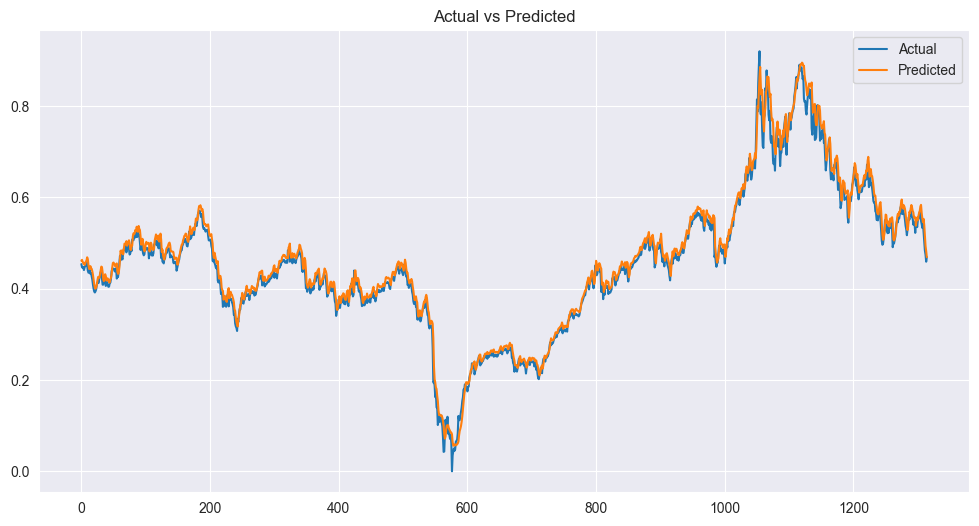

In [45]:
# Get the predicted values for the test set
y_pred = model.predict(test_sequences)

# Plot the predicted vs actual values
plt.figure(figsize=(12,6))
plt.plot(test_labels, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()


# Save the Model

In [46]:
model.save('model.h5')